In [44]:
import numpy as np
import scipy.signal as signal
import scipy.ndimage as nd
from skimage import color, io
import matplotlib.pyplot as plt
from skimage import feature
from skimage.filters import threshold_otsu
from queue import Queue
from skimage.filters import threshold_otsu

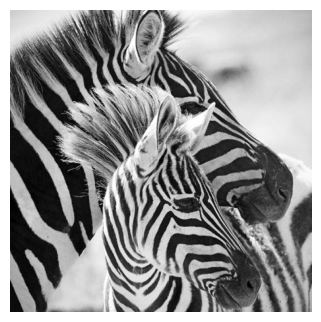

In [45]:
def normalize(image):
    return (image - np.min(image))/(np.max(image) - np.min(image))

image  = normalize(color.rgb2gray(io.imread('zebras.jpg')))

plt.figure(dpi=100)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

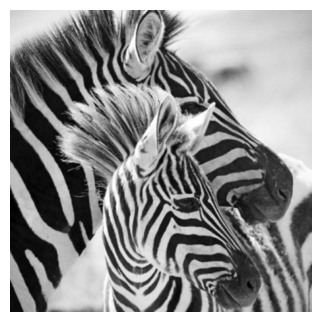

In [46]:
def gaussian_smoothing(image, sigma):
  return nd.gaussian_filter(image, sigma)

gaussian_image = gaussian_smoothing(image, 0.6)

plt.figure(dpi=100)
plt.imshow(gaussian_image, cmap='gray')
plt.axis('off')

plt.show()

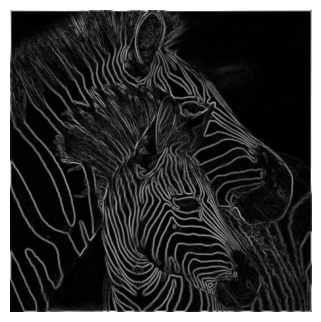

In [47]:
def calculate_gradients(image):
  window_x = np.array([        # Sobel filter
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]                     
  ])
  window_y = window_x.T
  gradient_x = signal.correlate2d(image, window_x)
  gradient_y = signal.correlate2d(image, window_y)

  gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)    
  gradient_angle = np.arctan2(gradient_y, gradient_x)*180/np.pi     

  return gradient_magnitude, gradient_angle

gradient_magnitude, gradient_angle = calculate_gradients(gaussian_image)

plt.figure(dpi=100)
plt.imshow(gradient_magnitude, cmap='gray')
plt.axis('off')

plt.show()

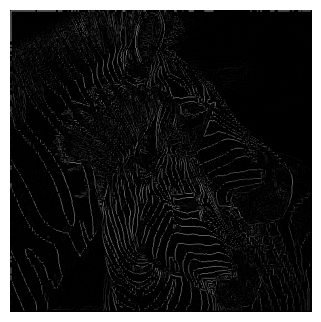

In [55]:
def non_maximum_supression(gradient_magnitude, gradient_angle):
  gradient_angle[gradient_angle < 0] += 180
  potential_edges = np.zeros(gradient_angle.shape)
  for y in range(1, gradient_angle.shape[0]-2):
    for x in range(1, gradient_angle.shape[1]-2):
      if (gradient_angle[y,x]>=0 and gradient_angle[y,x]<22.5) or (gradient_angle[y,x]>=157.5 and gradient_angle[y,x]<=180):   # --
        neighbour1 = gradient_magnitude[y, x-1]
        neighbour2 = gradient_magnitude[y, x+1]
      elif (gradient_angle[y,x]>=22.5 and gradient_angle[y,x]<67.5):   # /
        neighbour1 = gradient_magnitude[y+1, x-1]
        neighbour2 = gradient_magnitude[y-1, x+1]
      elif (gradient_angle[y,x]>=67.5 and gradient_angle[y,x]<112.5):   # |
        neighbour1 = gradient_magnitude[y-1, x]
        neighbour2 = gradient_magnitude[y+1, x]
      elif (gradient_angle[y,x]>=112.5 and gradient_angle[y,x]<157.5):   # \
        neighbour1 = gradient_magnitude[y-1, x-1]
        neighbour2 = gradient_magnitude[y+1, x+1]
        
      if (gradient_magnitude[y,x] > neighbour1) and (gradient_magnitude[y,x] > neighbour2):
        potential_edges[y,x] = gradient_magnitude[y,x]

  return potential_edges

potential_edges = non_maximum_supression(gradient_magnitude, gradient_angle)

plt.figure(dpi=100)
plt.imshow(potential_edges, cmap='gray')
plt.axis('off')

plt.show()

In [49]:
def otsu_threshold(gradient_magnitude):
  unique = np.unique(gradient_magnitude.ravel())
  our_bins = len(unique)
  hist, bins = np.histogram(gradient_magnitude.ravel(), bins=our_bins)

  probabilyty = hist/np.sum(hist)    
  threshold = 0

  for i in range(1, our_bins):      # searching threshold
    w1 = np.sum(probabilyty[:i])       
    w2 = np.sum(probabilyty[i:])      
    u1 = 0
    u2 = 0
    for j in range(1, i):
      u1 += bins[j] * probabilyty[j] / w1
    for j in range(i, our_bins):
      u2 += bins[j] * probabilyty[j] / w2
    sigma = w1 * w2 * (u2-u1)**2
    if sigma > threshold:
      threshold = sigma
  return threshold

threshold = threshold_otsu(gradient_magnitude)
print(threshold)

0.8631677877162118


In [50]:
def double_threshold(potential_edges, threshold):
  high_threshold = threshold
  low_threshold = threshold / 5
 
  strong_edges = np.zeros(potential_edges.shape)  
  weak_edges = np.zeros(potential_edges.shape)

  strong = 1 
  weak = 0.4
    
  strong_y, strong_x = np.where(potential_edges > high_threshold)
  weak_y, weak_x = np.where((potential_edges <= high_threshold) & (potential_edges >= low_threshold))
  
  strong_edges[strong_y, strong_x] = strong
  weak_edges[weak_y, weak_x] = weak  
    
  return strong_edges, weak_edges
  

strong_edges, weak_edges = double_threshold(potential_edges, threshold)

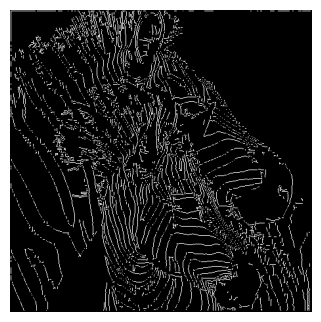

In [51]:
def edge_hysteresis(strong_edges, weak_edges):  
  strong_value = np.max(strong_edges)
  weak_value = np.max(weak_edges)

  image_neighbours = {}
  for y in range(1, strong_edges.shape[0]-2):
    for x in range(1, strong_edges.shape[1]-2):
      neighbours = [(y-1,x-1), (y-1,x), (y-1,x+1), (y,x-1), (y,x+1), (y+1,x-1), (y+1,x), (y+1,x+1)]
      image_neighbours[(y,x)] = neighbours             

  visited = [] 
  queue = Queue()   
  edges = strong_edges + weak_edges

  for y in range(1, edges.shape[0]-2):
    for x in range(1, edges.shape[1]-2):
      if (edges[y,x] == strong_value): 
        seed = (y,x)
        visited.append(seed)
        queue.put(seed) 
        while queue.empty() == False: 
          pixel = queue.get()
          for neighbour in image_neighbours[pixel]:    
            if neighbour not in visited:
              visited.append(neighbour)
              if (edges[neighbour] == weak_value):
                queue.put(neighbour)
                edges[neighbour] = strong_value
  
  edges[np.where(edges == weak_value)] = 0
  return edges

edges = edge_hysteresis(strong_edges, weak_edges)

plt.figure(dpi=100)
plt.imshow(edges, cmap='gray')
plt.axis('off')
plt.show()

In [52]:
def canny(image, sigma=0.6):

  gaussian_image = gaussian_smoothing(image, sigma)
  gradient_magnitude, gradient_angle = calculate_gradients(gaussian_image)
  potential_edges = non_maximum_supression(gradient_magnitude, gradient_angle) 
  threshold = threshold_otsu(gradient_magnitude)
  strong_edges, weak_edges = double_threshold(potential_edges, threshold) 
  canny_image = edge_hysteresis(strong_edges, weak_edges)

  return canny_image

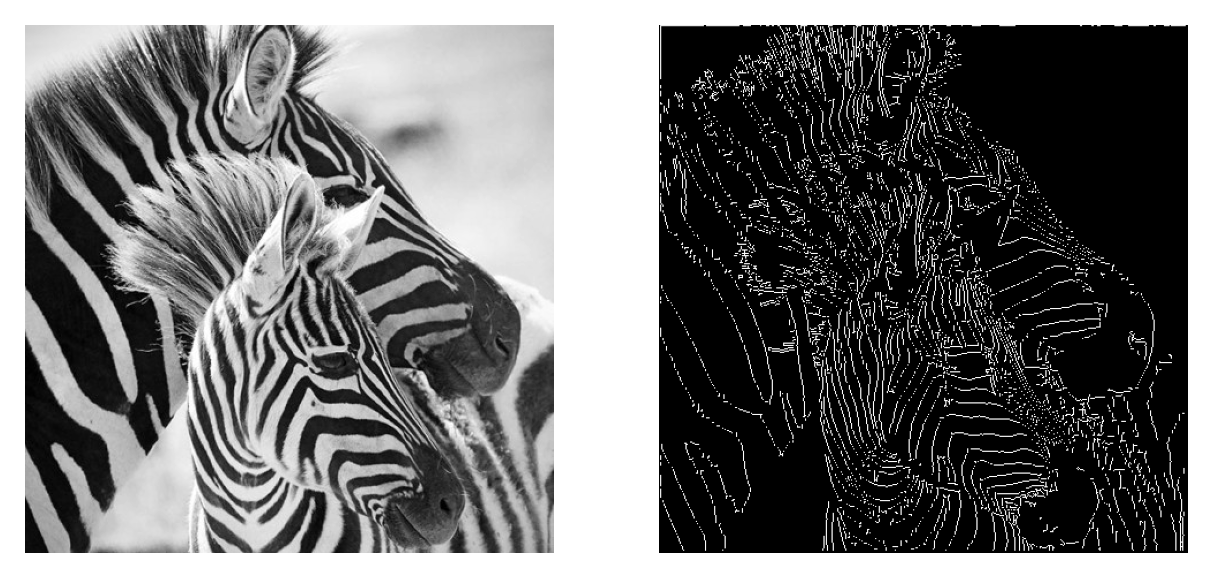

In [53]:
canny_image = canny(image)

plt.figure(dpi=250)
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(canny_image, cmap='gray')
plt.axis('off')
plt.show()

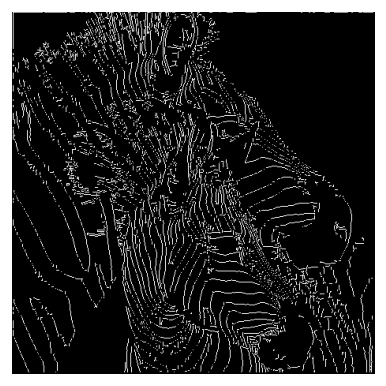

In [54]:
plt.figure(dpi=120)
plt.imshow(canny_image, cmap='gray')
plt.axis('off')
plt.show()